<a href="https://colab.research.google.com/github/Myrnyi-Yehor/Online-store-sales-analytics/blob/main/Online_store_sales_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Завантаження датасету

In [ ]:
!pip install --upgrade google-cloud-bigquery


In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project="data-analytics-mate", default_query_job_config=bigquery.QueryJobConfig(default_dataset="data-analytics-mate.DA"))

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
query = """
WITH registration_account_info AS(
  SELECT
    acs.ga_session_id as ga_session_id,
    acs.account_id as account_id,
    a.is_unsubscribed as is_unsubscribed,
    a.is_verified as is_verified,
    a.send_interval as send_interval
  FROM `data-analytics-mate.DA.account_session` as acs
  INNER JOIN `data-analytics-mate.DA.account` as a
  ON acs.account_id = a.id
)

SELECT
  s.date as order_date,
  s.ga_session_id as session_id,
  sp.continent as continent,
  sp.country as country,
  sp.device as device,
  sp.browser as browser,
  sp.operating_system as operating_system,
  sp.language as language_browser,
  sp.name as traffic_source_information,
  sp.channel as channel,
  CASE WHEN registration_account_info.ga_session_id IS NOT NULL THEN True ELSE False END as is_registration,
  registration_account_info.is_verified = 1 as is_verified,
  registration_account_info.is_unsubscribed = 0 as is_subscribed,
  p.category as product_category,
  p.name as product_name,
  p.price as product_price,
  p.short_description as product_short_description
FROM `data-analytics-mate.DA.session` as s
LEFT JOIN `data-analytics-mate.DA.order` as o
ON o.ga_session_id = s.ga_session_id
LEFT JOIN `data-analytics-mate.DA.session_params` as sp
ON s.ga_session_id = sp.ga_session_id
LEFT JOIN registration_account_info
ON s.ga_session_id = registration_account_info.ga_session_id
LEFT JOIN `data-analytics-mate.DA.product` as p
ON o.item_id = p.item_id
"""
data = client.query(query).to_dataframe()
data.head()


,order_date,session_id,continent,country,device,browser,operating_system,language_browser,traffic_source_information,channel,is_registration,is_verified,is_subscribed,product_category,product_name,product_price,product_short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Macintosh,zh,<Other>,Paid Search,False,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Web,en-us,(organic),Organic Search,False,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,Web,zh,(direct),Direct,False,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,Android,es-es,(direct),Direct,False,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Windows,en-us,(direct),Direct,False,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


## 2. Опис отриманих данних

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   order_date                  349545 non-null  dbdate 
 1   session_id                  349545 non-null  Int64  
 2   continent                   349545 non-null  object 
 3   country                     349545 non-null  object 
 4   device                      349545 non-null  object 
 5   browser                     349545 non-null  object 
 6   operating_system            349545 non-null  object 
 7   language_browser            235279 non-null  object 
 8   traffic_source_information  349545 non-null  object 
 9   channel                     349545 non-null  object 
 10  is_registration             349545 non-null  boolean
 11  is_verified                 27945 non-null   boolean
 12  is_subscribed               27945 non-null   boolean
 13  product_catego

In [ ]:
data["order_date"] = pd.to_datetime(data["order_date"])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 17 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_date                  349545 non-null  datetime64[ns]
 1   session_id                  349545 non-null  Int64         
 2   continent                   349545 non-null  object        
 3   country                     349545 non-null  object        
 4   device                      349545 non-null  object        
 5   browser                     349545 non-null  object        
 6   operating_system            349545 non-null  object        
 7   language_browser            235279 non-null  object        
 8   traffic_source_information  349545 non-null  object        
 9   channel                     349545 non-null  object        
 10  is_registration             349545 non-null  boolean       
 11  is_verified                 27945 non-n

In [ ]:
count_columns = data.shape[1]
numbers_columns = list(data.select_dtypes(include = ["number"]).columns)
#count_numbers_columns = data.select_dtypes(include = [np.number]).shape[1]
categorical_columns = list(data.select_dtypes(include = ["object", "category"]).columns)
count_datetime_columns = data.select_dtypes(include = ["datetime64"]).shape[1]
count_unique_sessions = data["session_id"].nunique()
first_order_date = data["order_date"].min().date()
lust_order_date = data["order_date"].max().date()
missing_values = pd.DataFrame({
    "Count missing": data.isna().sum(),
    "% missing": (data.isna().sum()/count_unique_sessions * 100).round(2)
})

print(f"Кількість колонок: {count_columns}")
print(f"Кількість числових колонок: {len(numbers_columns)}")
print(f"Числові колонки: \n{numbers_columns}")
print(f"Кількість категоріальних колонок: {len(categorical_columns)}")
print(f"Категоріальні колонки: \n{categorical_columns}")
print(f"Кількість колонок типу datetime: {count_datetime_columns}")
print(f"Кількість унікальних сесій: {count_unique_sessions}")
print(f"Період часу від {first_order_date} до {lust_order_date}")

print(f"\nНаявність пропущенних значень: \n{missing_values}")

Кількість колонок: 17
Кількість числових колонок: 2
Числові колонки: 
['session_id', 'product_price']
Кількість категоріальних колонок: 11
Категоріальні колонки: 
['continent', 'country', 'device', 'browser', 'operating_system', 'language_browser', 'traffic_source_information', 'channel', 'product_category', 'product_name', 'product_short_description']
Кількість колонок типу datetime: 1
Кількість унікальних сесій: 349545
Період часу від 2020-11-01 до 2021-01-31

Наявність пропущенних значень: 
                            Count missing  % missing
order_date                              0       0.00
session_id                              0       0.00
continent                               0       0.00
country                                 0       0.00
device                                  0       0.00
browser                                 0       0.00
operating_system                        0       0.00
language_browser                   114266      32.69
traffic_source_informati

#### Велика кількість пропущених значень в колонках is_verified та is_subscribed, це пов'язано з тим, що користувач не зареєстрований, тому інформації про верифікацію та підпис на емейл розсилку немає  
#### Пропущені значення в данних о продуктах так як під час цих сесій не було здійснено замовлення
#### Пропущені значення в мові браузера, бо не завжди ми можемо отримати цю інформацію

## 3. Описовий аналіз

### 3.1 Топ 3 континенти за продажами

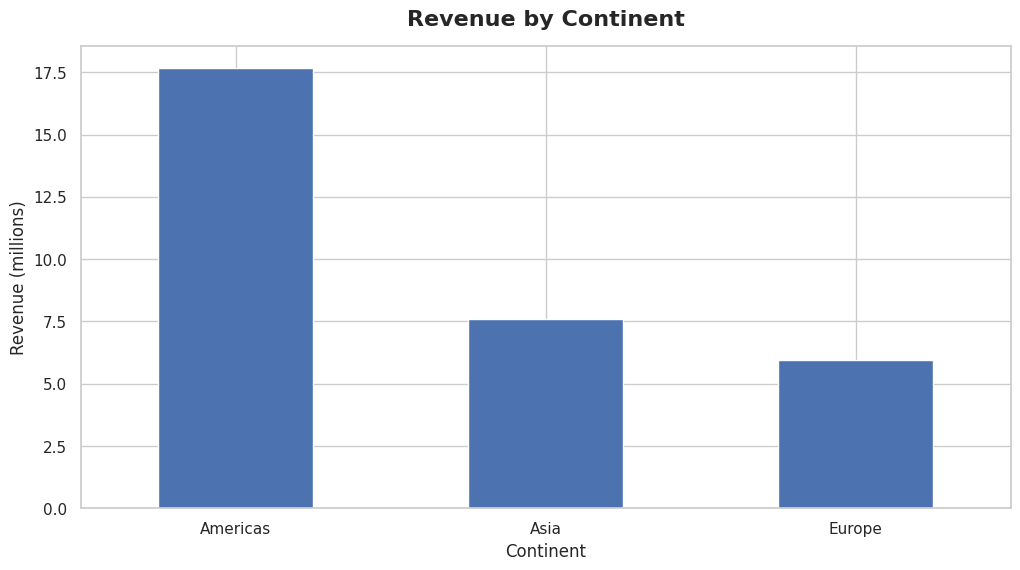

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
top3_continent_by_revenue = data.groupby("continent")["product_price"].sum().nlargest(3).sort_values(ascending=False)
sns.set_theme(style="whitegrid")
top3_continent_by_revenue.plot(kind="bar", figsize = (12, 6))
plt.xlabel("Continent", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue (millions)", fontsize=12)
plt.title(f"Revenue by Continent", fontsize=16, fontweight='bold', pad=15)
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}')
)
plt.show()

### 3.2 Топ 3 континенти за кількістю замовлень

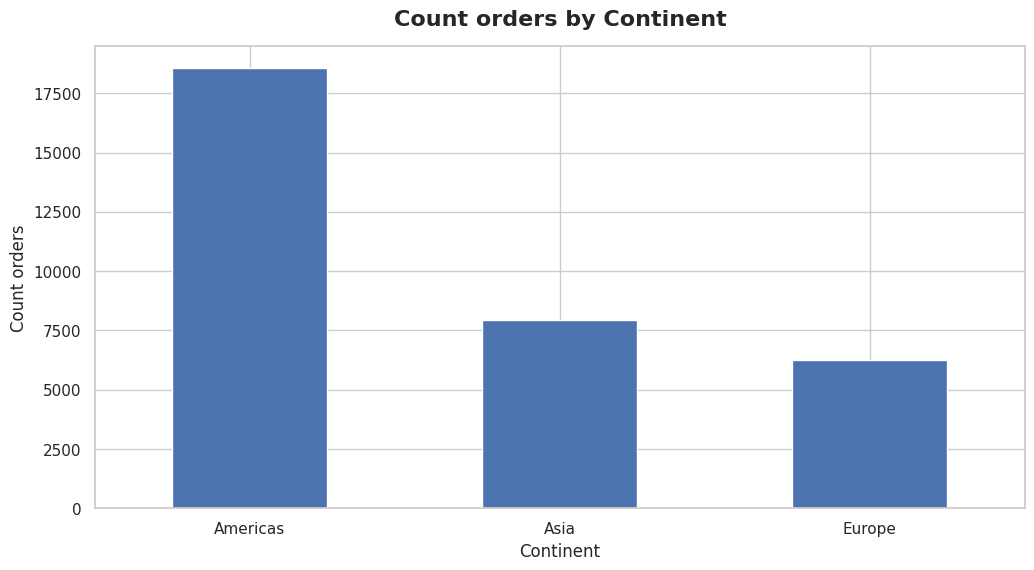

In [ ]:
top3_continent_by_order = data.groupby("continent")["product_price"].count().nlargest(3).sort_values(ascending=False)
sns.set_theme(style="whitegrid")
top3_continent_by_order.plot(kind="bar", figsize = (12, 6))
plt.xlabel("Continent", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Count orders", fontsize=12)
plt.title(f"Count orders by Continent", fontsize=16, fontweight='bold', pad=15)

plt.show()

### 3.3 Топ 5 країн за доходом

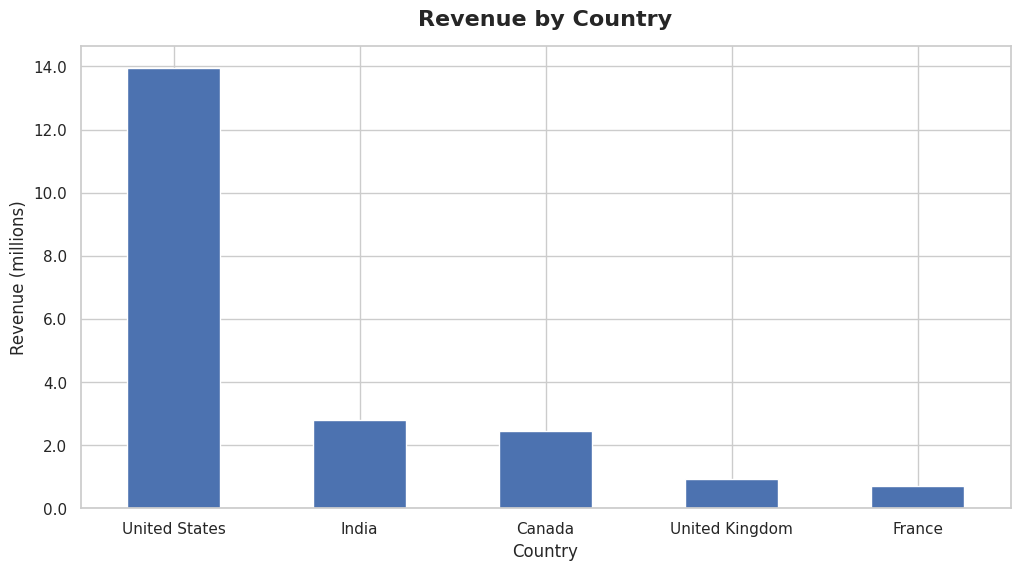

In [ ]:
top5_contries_by_revenue = data.groupby("country")["product_price"].sum().nlargest(5).sort_values(ascending=False)
sns.set_theme(style="whitegrid")
top5_contries_by_revenue.plot(kind="bar", figsize = (12, 6))
plt.xlabel("Country", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue (millions)", fontsize=12)
plt.title(f"Revenue by Country", fontsize=16, fontweight='bold', pad=15)
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}')
)
plt.show()

### 3.4 Топ 5 країн за кількістю замовлень

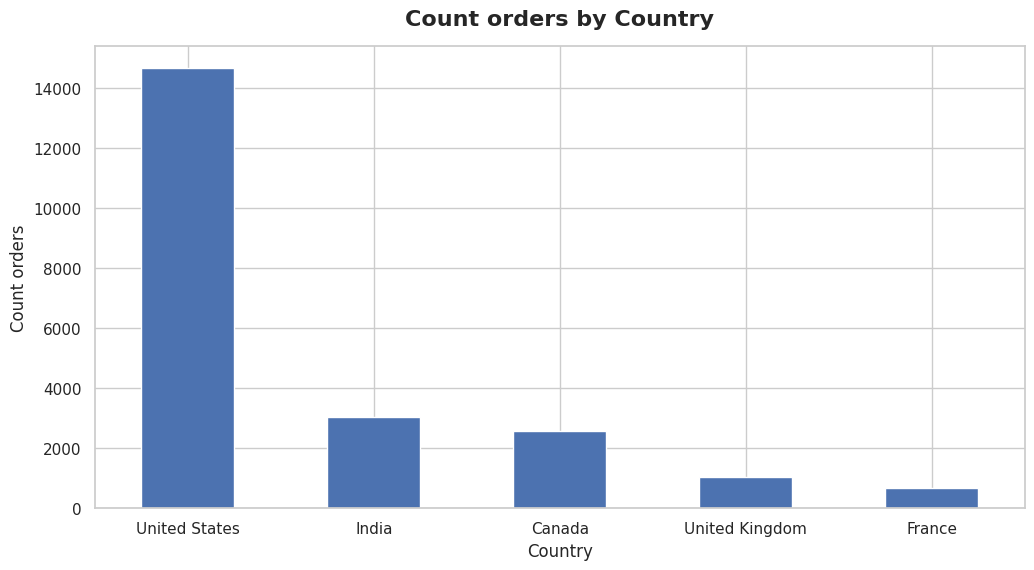

In [ ]:
top5_contries_by_orders = data.groupby("country")["product_price"].count().nlargest(5).sort_values(ascending=False)
sns.set_theme(style="whitegrid")
top5_contries_by_orders.plot(kind="bar", figsize = (12, 6))
plt.xlabel("Country", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Count orders", fontsize=12)
plt.title(f"Count orders by Country", fontsize=16, fontweight='bold', pad=15)

plt.show()

### 3.5 Топ 10 категорій товару за загальною сумою продажів

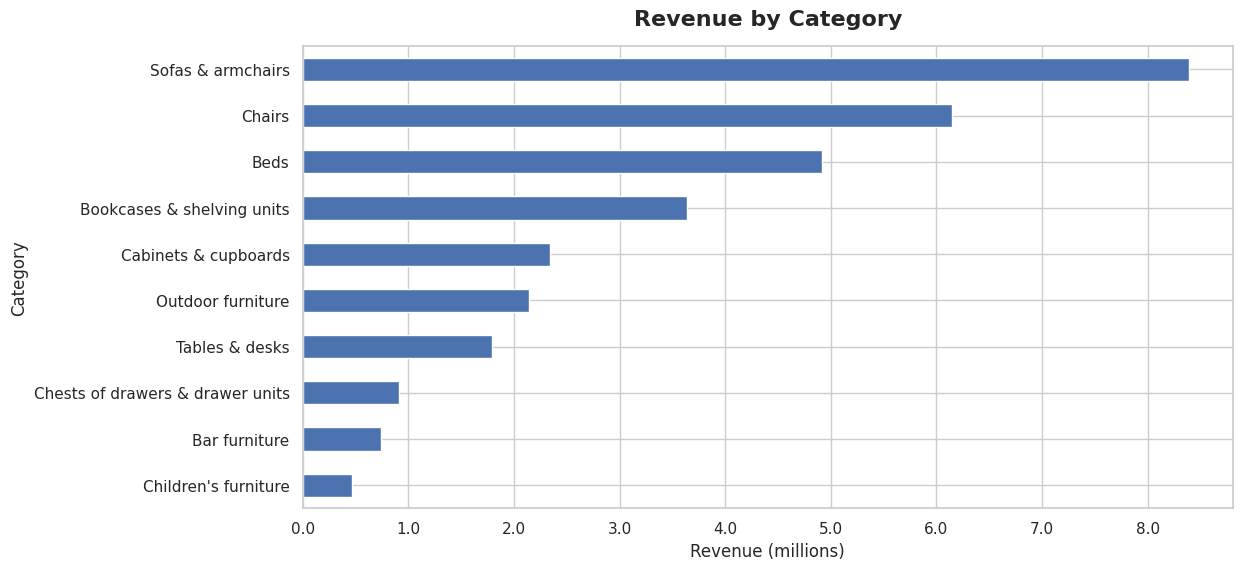

In [ ]:
top10_categories = data.groupby("product_category")["product_price"].sum().nlargest(10).sort_values(ascending=True)
sns.set_theme(style="whitegrid")
top10_categories.plot(kind="barh", figsize = (12, 6))
plt.xlabel("Revenue (millions)", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Category", fontsize=12)
plt.title(f"Revenue by Category", fontsize=16, fontweight='bold', pad=15)
plt.gca().get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}')
)
plt.show()

### 3.6 Продажі у розрізі типів та моделей девайсів (у % від загальних продажів)

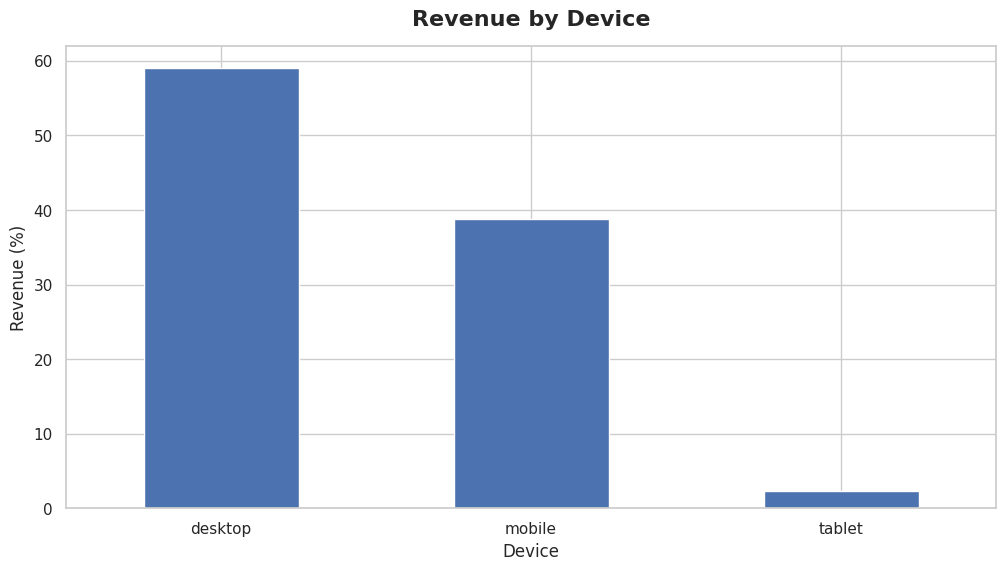

In [ ]:
revenue_by_device = data.groupby("device")["product_price"].sum().sort_values(ascending=False)
revenue_by_device_percent = revenue_by_device / revenue_by_device.sum() * 100
sns.set_theme(style="whitegrid")
revenue_by_device_percent.plot(kind="bar", figsize = (12, 6))
plt.xlabel("Device", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue (%)", fontsize=12)
plt.title(f"Revenue by Device", fontsize=16, fontweight='bold', pad=15)

plt.show()

### 3.7 Продажі за джерелами трафіку (у % від загальних продажів)

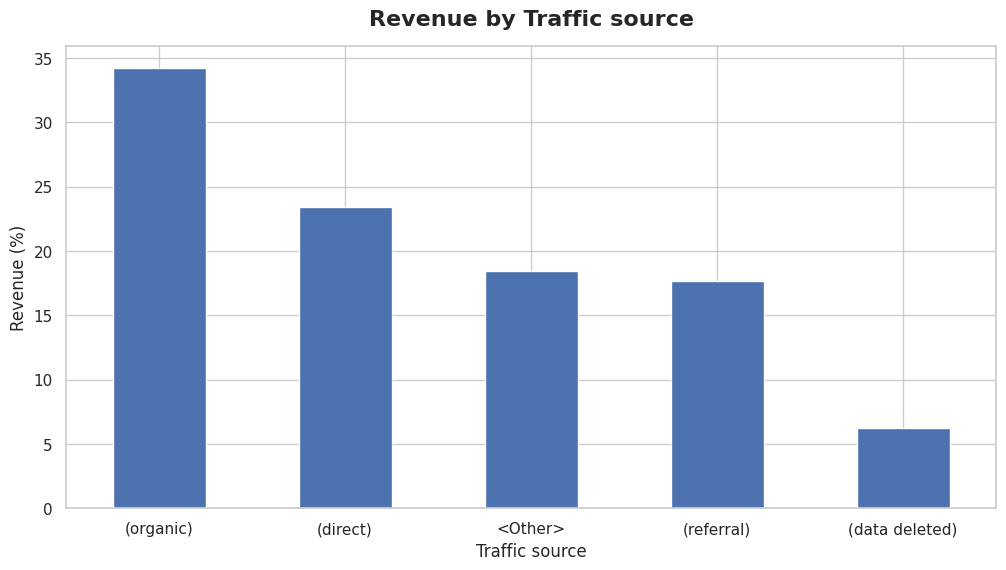

In [ ]:
revenue_by_traffic_source = data.groupby("traffic_source_information")["product_price"].sum().sort_values(ascending=False)
revenue_by_traffic_source = revenue_by_traffic_source / revenue_by_traffic_source.sum() * 100
sns.set_theme(style="whitegrid")
revenue_by_traffic_source.plot(kind="bar", figsize = (12, 6))
plt.xlabel("Traffic source", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue (%)", fontsize=12)
plt.title(f"Revenue by Traffic source", fontsize=16, fontweight='bold', pad=15)

plt.show()

## 4. Аналіз динаміки продажів

### 4.1 Загальна динаміка продажів

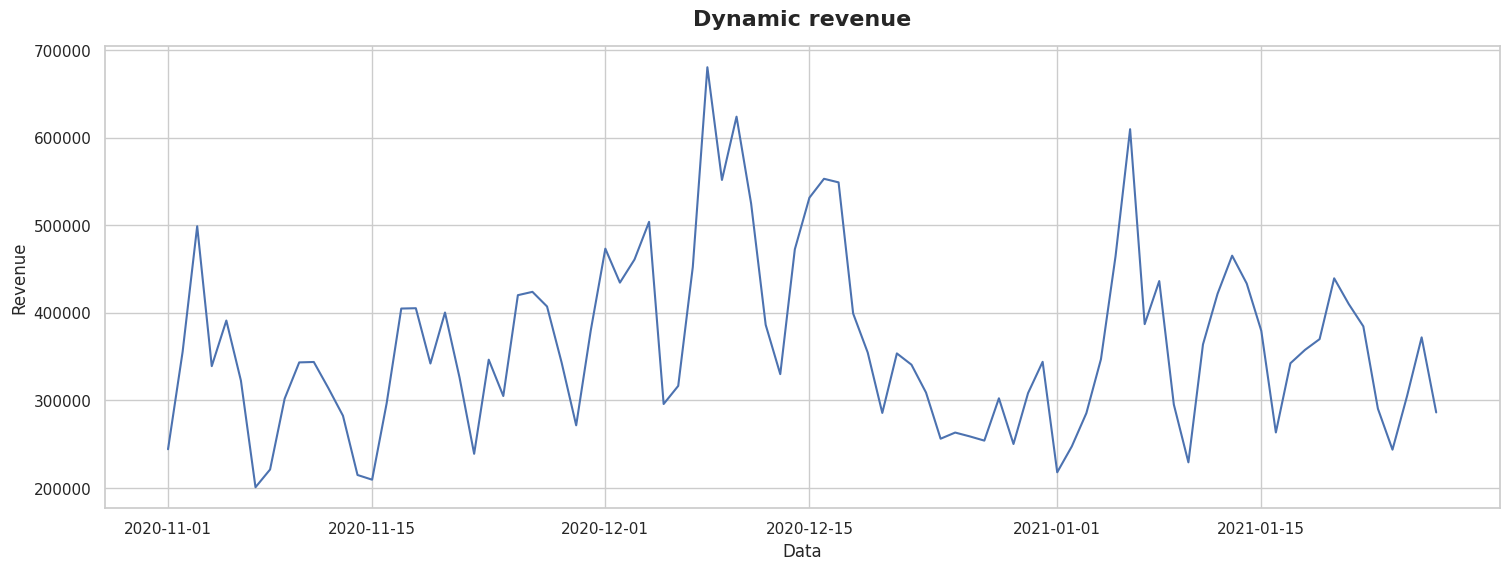

In [ ]:
revenue_dynamic = data.groupby("order_date", as_index = False)["product_price"].sum()
revenue_dynamic = revenue_dynamic[revenue_dynamic["product_price"] != 0]

plt.figure(figsize = (18, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data = revenue_dynamic, x = "order_date", y = "product_price")
plt.xlabel("Data", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue", fontsize=12)
plt.title(f"Dynamic revenue", fontsize=16, fontweight='bold', pad=15)

plt.show()

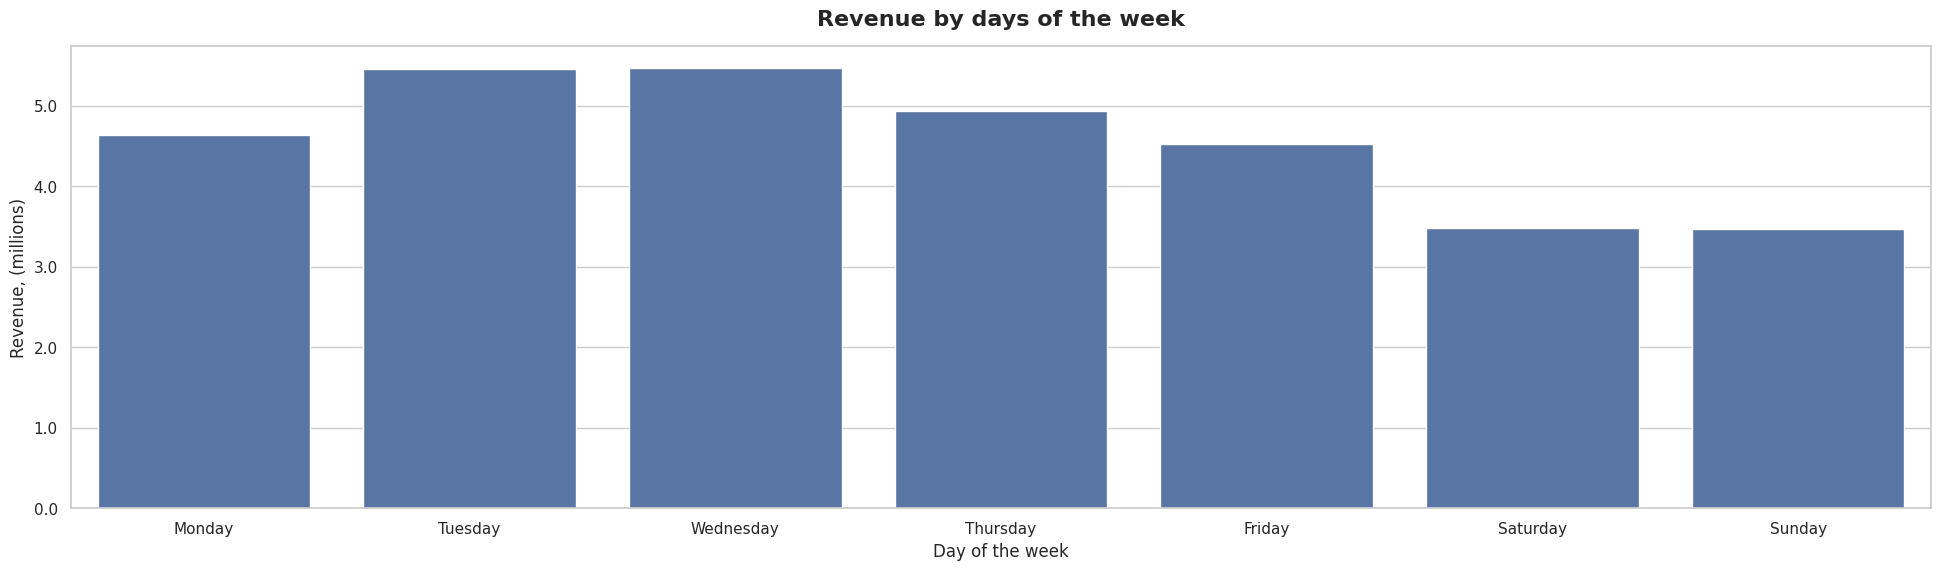

In [ ]:
revenue_by_days_of_the_week = data.copy()
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
revenue_by_days_of_the_week["day_name"] = pd.Categorical(revenue_by_days_of_the_week["order_date"].dt.day_name(), categories=order, ordered=True)
revenue_by_days_of_the_week = revenue_by_days_of_the_week.groupby("day_name", as_index=False, observed=True)["product_price"].sum()

plt.figure(figsize=(24, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x="day_name", y="product_price", data=revenue_by_days_of_the_week)
plt.title("Revenue by days of the week", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Day of the week", fontsize=12)
plt.ylabel("Revenue, (millions)", fontsize=12)
plt.gca().get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}')
)
plt.show()

### З попередніх графіків видно, що до початку нового року дохід зростає, після 15.12.2020 різко падає та зберігає малі значення до нового року. Після 01.01.2021 дохід різко зростає після чого повільно йде на спад. Також з другого графіка ми можемо побачити зменшення доходу на вихідних, що з бігається з постіними локальними спадами доходу на першому графіку

### 4.2 Динаміка продажів в Америці, Азії та Європі

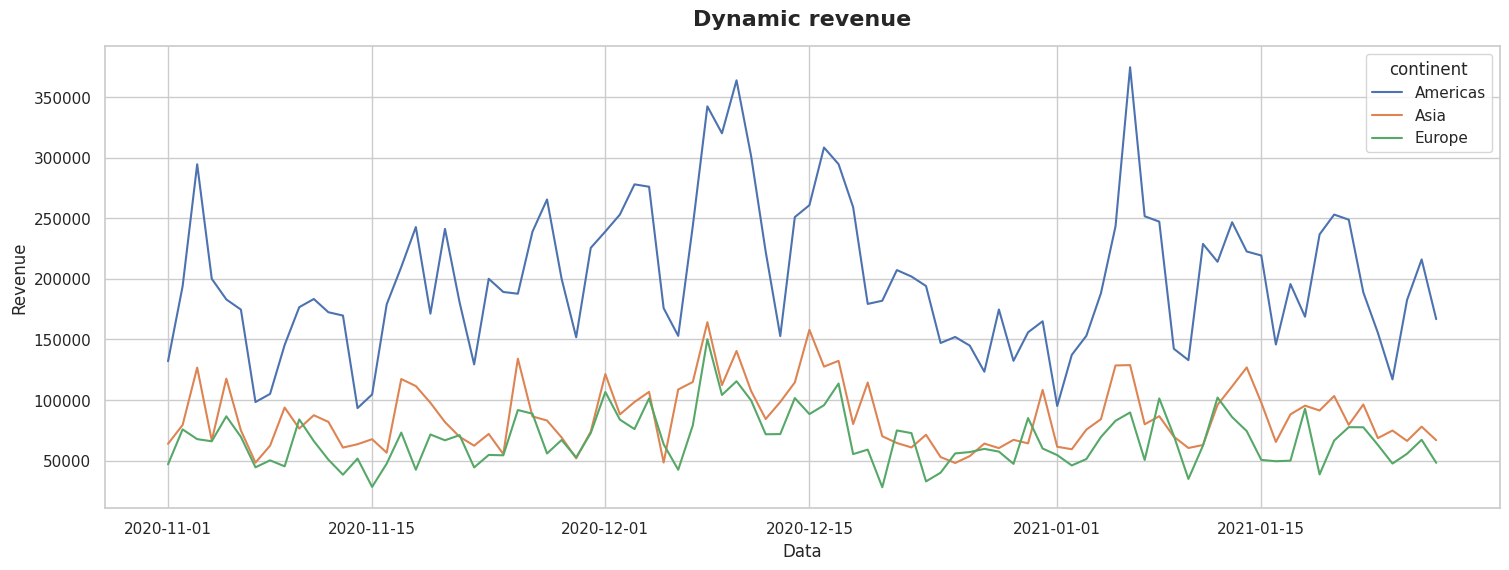

In [ ]:
revenue_dynamic_by_continent = data.groupby(["continent", "order_date"], as_index = False)["product_price"].sum()
revenue_dynamic_by_continent = revenue_dynamic_by_continent[revenue_dynamic_by_continent["product_price"] != 0]
show_continent = ["Americas", "Asia", "Europe"]
revenue_dynamic_America_Asia_Europe = revenue_dynamic_by_continent[revenue_dynamic_by_continent["continent"].isin(show_continent)]

plt.figure(figsize = (18, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data = revenue_dynamic_America_Asia_Europe, x = "order_date", y = "product_price", hue = "continent")
plt.xlabel("Data", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue", fontsize=12)
plt.title(f"Dynamic revenue", fontsize=16, fontweight='bold', pad=15)

plt.show()

Americas  
Має найвищий дохід серед трьох континентів.
Виступає як основний драйвер загального доходу.
Є помітні піки доходу приблизно:  
на початку листопада 2020  
початок грудня 2020  
початок січня 2021  
Піки досить різкі, що може свідчити про сезонні акції, святкові періоди або великі замовлення.  
Asia  
Дохід середній, стабільний, але з меншими коливаннями, ніж Americas.  
Теж є періодичні піки, але вони не такі виражені.  
Загальна тенденція — трохи зростаюча наприкінці грудня, потім стабілізується.  
Europe  
Найнижчий дохід серед трьох.  
Коливання доходу схожі на Asia, але менші.  
Схоже на стабільний, відносно рівномірний ринок, без різких піків.

### 4.3 Динаміка продажів у розрізі каналів трафіку

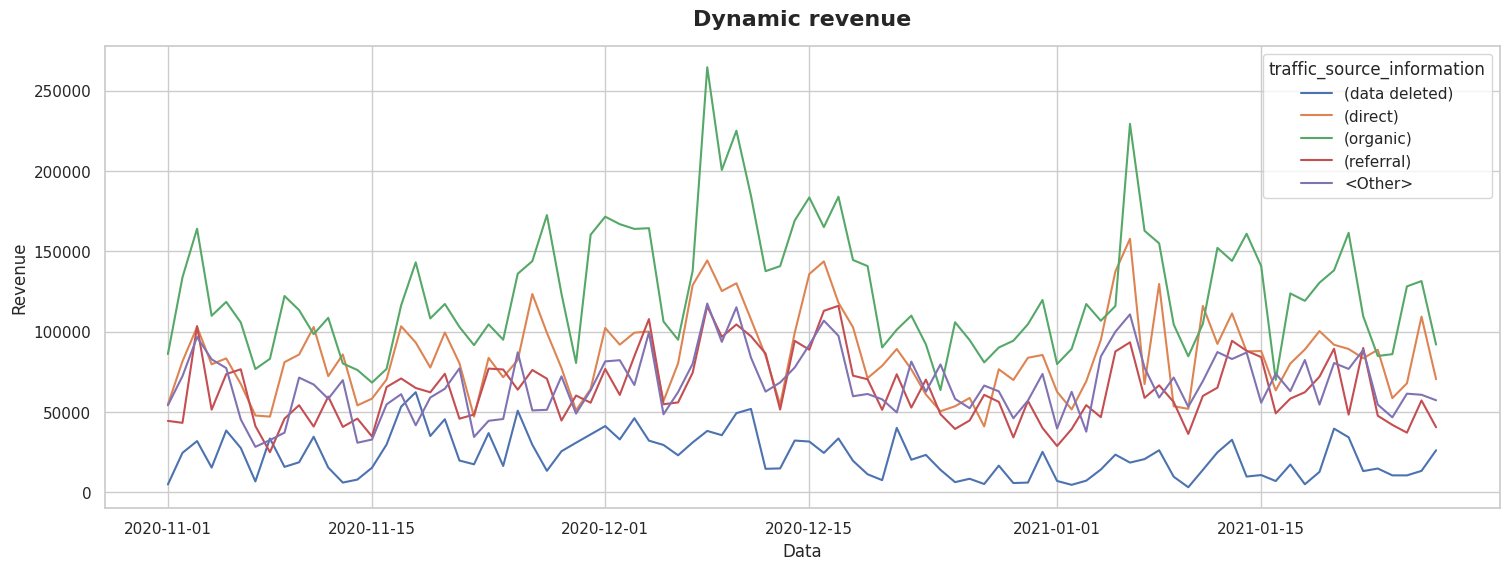

In [ ]:
revenue_dynamic_by_traffic_source = data.groupby(["traffic_source_information", "order_date"], as_index = False)["product_price"].sum()
revenue_dynamic_by_traffic_source = revenue_dynamic_by_traffic_source[revenue_dynamic_by_traffic_source["product_price"] != 0]

plt.figure(figsize = (18, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data = revenue_dynamic_by_traffic_source, x = "order_date", y = "product_price", hue = "traffic_source_information")
plt.xlabel("Data", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue", fontsize=12)
plt.title(f"Dynamic revenue", fontsize=16, fontweight='bold', pad=15)

plt.show()

Органічний трафік (organic) стабільно приносить найбільший дохід. Спостерігаються піки на початку грудня та початку січня – можливо, сезонні фактори чи акції.  
Прямий трафік (direct) другий за доходом, також демонструє коливання, але не так різко, як органіка.  
Реферальний трафік (referral) і (Other) приблизно однакові за рівнем доходу, з невеликими піками та падіннями.  
(data deleted) – найнижчий дохід серед усіх категорій, але видно стабільний тренд з невеликим зростанням у грудні.

### 4.4 Динаміка продажів у розрізі типів девайсів

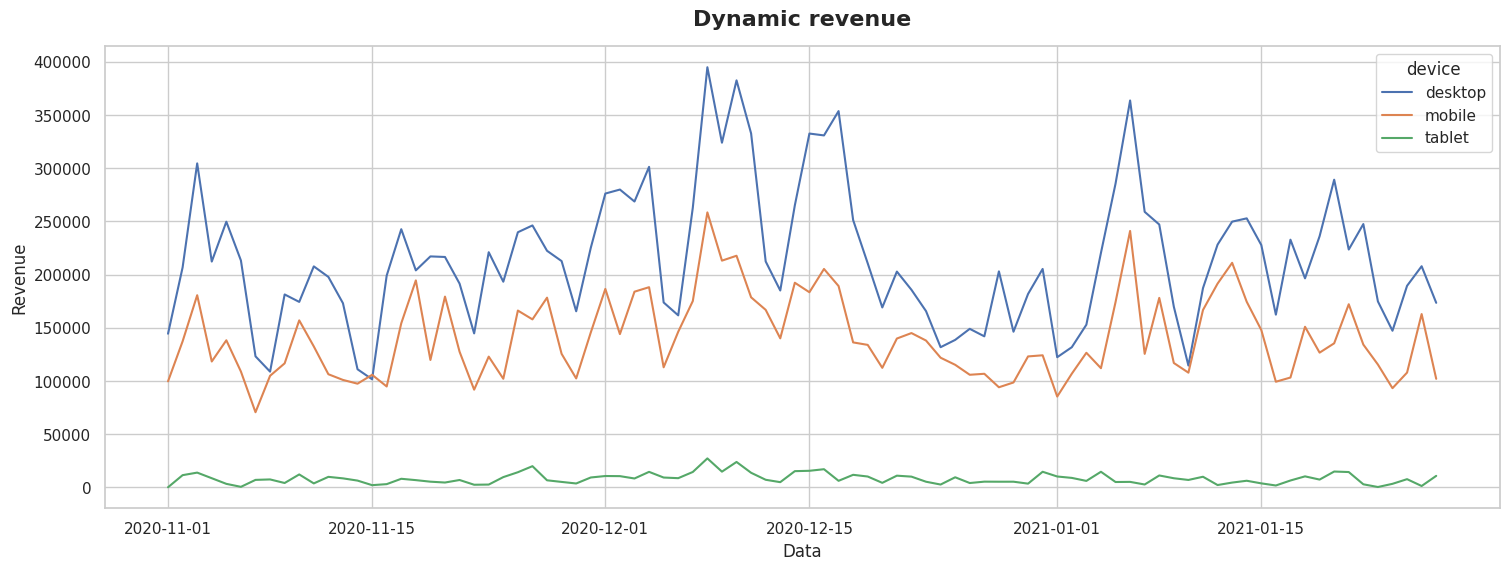

In [ ]:
revenue_dynamic_by_device = data.groupby(["device", "order_date"], as_index = False)["product_price"].sum()
revenue_dynamic_by_device = revenue_dynamic_by_device[revenue_dynamic_by_device["product_price"] != 0]

plt.figure(figsize = (18, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(data = revenue_dynamic_by_device, x = "order_date", y = "product_price", hue = "device")
plt.xlabel("Data", fontsize=12)
plt.xticks(rotation=0)
plt.ylabel("Revenue", fontsize=12)
plt.title(f"Dynamic revenue", fontsize=16, fontweight='bold', pad=15)

plt.show()

Desktop — основне джерело доходу  
Доходи з desktop стабільно найвищі серед усіх пристроїв.
Спостерігаються регулярні коливання, із піками  
Mobile — друга за обсягом категорія  
Доходи з mobile становлять приблизно половину desktop-рівня  
Динаміка подібна до desktop — є синхронні сплески, що може вказувати на спільні акційні періоди або сезони.  
Tablet — мінімальний внесок  
Доходи з tablet майже непомітні.  
Це свідчить, що цей канал продажів майже незначний.  
Ймовірно, користувачів планшетів дуже мало, або їх поведінка суттєво відрізняється.  
Сезонність і коливання  
Є повторювані піки через 1–2 тижні, що може бути пов’язано з акціями, вихідними.  
У грудні (перед святами) помітно зростання доходів на всіх пристроях — типова поведінка для e-commerce.

## 5. Створення зведених таблиць

### 5.1 Зведена таблиця, кількості сесій у розрізі каналів трафіку та типів девайсів

In [ ]:
pivot_table_channel_device = data.pivot_table(index = "channel", columns = "device", values = "session_id", aggfunc = "count")
display(pivot_table_channel_device)

device,desktop,mobile,tablet
channel,,,
Direct,47825,31745,1812
Organic Search,72622,49014,2789
Paid Search,55167,37034,2140
Social Search,16288,10988,638
Undefined,12527,8486,470


### 5.2 Зведена таблиця, загальних продажів за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)

In [ ]:
pivot_table_category_country = data.pivot_table(index = "product_category", columns = "country", values = "product_price", aggfunc = "sum").fillna(0)
top10_categories = pivot_table_category_country.sum(axis = 1).nlargest(10).index
top5_countries = pivot_table_category_country.sum(axis = 0).nlargest(5).index
pivot_table_top10_categories_top5_countries = pivot_table_category_country.loc[top10_categories, top5_countries]
display(pivot_table_top10_categories_top5_countries)

country,United States,India,Canada,United Kingdom,France
product_category,,,,,
Sofas & armchairs,3707144.5,788430.0,692427.5,234812.0,187735.0
Chairs,2619773.8,544309.2,417740.8,188519.4,134029.4
Beds,2213058.0,358319.5,354772.0,133816.0,116414.0
Bookcases & shelving units,1567606.9,364507.4,278981.9,113987.6,73830.0
Cabinets & cupboards,994545.5,191888.0,181802.0,71684.5,59101.5
Outdoor furniture,929245.2,162289.4,185322.8,57002.4,40486.4
Tables & desks,777865.0,186157.5,132678.0,49374.0,42299.0
Chests of drawers & drawer units,382388.0,73111.0,71952.0,36784.0,21544.5
Bar furniture,330805.0,57657.0,51724.0,22103.0,11199.0


## 6. Статистичний аналіз взаємозв’язків.

### 6.1 Дослідження кореляції між загальними продажами та кількістю сесій

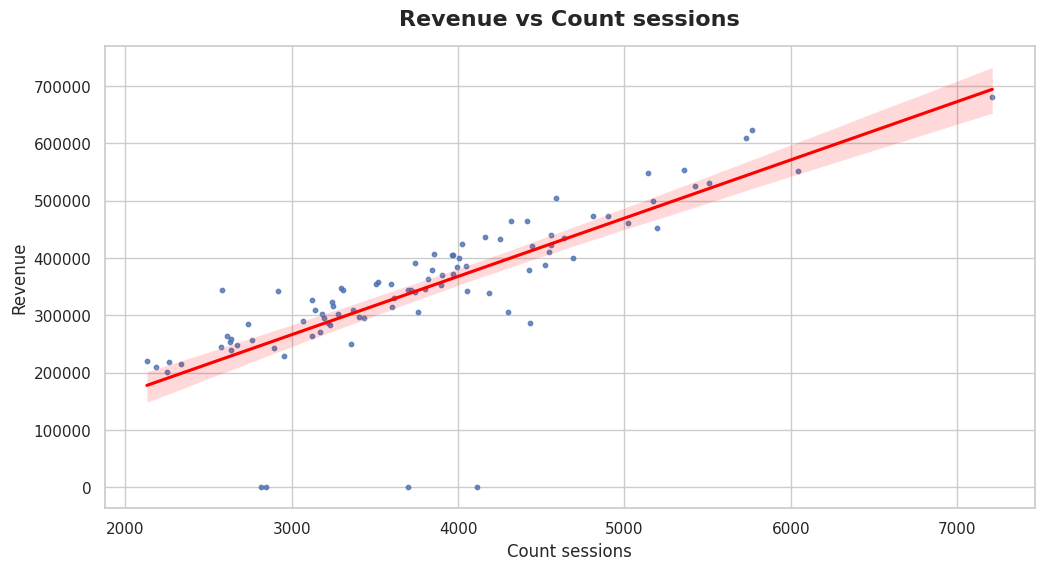

In [ ]:
revenue_session_by_date = data.groupby("order_date", as_index = False)["session_id"].count()
revenue_session_by_date["revenue"] = data.groupby("order_date")["product_price"].sum().values

plt.figure(figsize = (12, 6))
sns.set_theme(style="whitegrid")
sns.regplot(data = revenue_session_by_date, x = "session_id", y = "revenue", scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title("Revenue vs Count sessions", fontsize=16, fontweight='bold', pad=15)
plt.xlabel("Count sessions", fontsize=12)
plt.ylabel("Revenue", fontsize=12)

plt.show()

Досліджуємо на нормальність розподілу

In [ ]:
from scipy.stats import normaltest

_, p_value_count_sessions = normaltest(revenue_session_by_date["session_id"])
_, p_value_revenue = normaltest(revenue_session_by_date["revenue"])

print(f"p value для кількості сесій по дням: {p_value_count_sessions}")
print(f"p value для доходу по дням: {p_value_revenue}")

p value для кількості сесій по дням: 0.008655428822366544
p value для доходу по дням: 0.021085752302202193


Як ми бачимо p-value < 0.05, отже для дослідження кореляції викорисаємо коефіцієнт Спірмена

In [ ]:
from scipy.stats import spearmanr

print(
    f"Test statistic and p-value: {spearmanr(revenue_session_by_date['session_id'], revenue_session_by_date['revenue'])}"
)

spearman_corr = revenue_session_by_date['session_id'].corr(
    revenue_session_by_date['revenue'], method="spearman"
)
print(f"Spearman Correlation: {spearman_corr}")

Test statistic and p-value: SignificanceResult(statistic=np.float64(0.8653062174563682), pvalue=np.float64(9.755923586156614e-29))
Spearman Correlation: 0.8653062174563682


Так як p-value < 0.05, то залежність статистично значуща, при цьому коефіцієнт Спірмена 0.865, що може свідчити про сильну позитивну кореляцію. Тобто кількість сесій по дням позитивно впливає на значення доходу в день